# Predicting Cardiovascular Disease 

### Project Overview: 

**The Problem**
Cardiovascular Heart Disease (CHD) is the leading cause of death annually worldwide. Cardiovascular Diseases can, however, be managed if caught early and simple lifestyle changes are made. This project would explore a set of data for patients measuring known factors for heart disease to develop a machine learning model to predict risk of developing heart disease within the next ten years. 


**The Client:**
A small clinic in Framingham, Massachusetts has seen a decided spike in cases of cardiovascular disease in their patients. Rather than sit back and wait for illness to strike, the lead cardiologist has decided to be proactive. They’ve reached out to us to review their clinical data and develop a model to predict their patient’s risk of developing cardiovascular disease in the next 10 years. The physician has two goals in mind: help identify those at risk and start acting before things get worse, and determine which patients are statistically more likely to develop problems and provide them with educational material before things become a problem. The model developed from their patient dataset will be used to do exactly that. A statistical model will be used to develop a patient education program, targeted at specific potential risk patients, and to help bring awareness surrounding cardiovascular disease before it becomes a problem. A machine learning model will also be used to target identified “at risk” patients and help them combat more severe cardiovascular disease by targeting treatment and making recommended life-style changes for those patients who are identified as being at risk.

**Exploratory Data Analysis and Visualization** 
Exploratory Data Analysis and visualization can be found in [this jupyter notebook](https://github.com/CJEJansson/Springboard_Projects/blob/master/Capstone%202/Predicting%20Cardiovascular%20Disease.ipynb).

Overall, the data showed results expected, and the results found here were consistent with those results found by the researchers doing the study. The risk of developing CHD is increased with smoking, and the more a patient smokes per day the higher the risk. High cholesterol and high blood pressure (looking at both systolic and diastolic) increase the risk of developing CHD. Increase of developing CHD increases with age. Patients with a prevalence of stroke, hypertension, and diabetes all also increase the risk of developing CHD with age. 

Knowing from the full study that risk of CHD can be decreased, it would have been interesting to study this as part of the project, but this data was not included in the provided dataset for analysis. These insights can be leveraged by the client to target specific patient groups and ultimately lower the risk of developing CHD. It is hoped that these insights will lend themselves to the development of an accurate risk prediction engine as the project continues. 

**In-Depth Analysis**

At this point, we will move on to a more in depth analysis by developing a series of Machine Learning Models. These models will be used to perform predictions using the features provided in the dataset to determine if there is a risk of a patient developing Cardiovascular Heart Disease in the next decade. Before developing models we will begin by removing nulls from the data set, in a similar manner to that utilized during Exploratory Data Analysis (EDA). We will then split the training data into a train/test set to train our models. These models will then be used to analyze the test portion of the data and validate the model. 

In [26]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns

#Test-Train Split and Confusion Matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, plot_confusion_matrix

#Import Modeling methods 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


#Under and Over Sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#LightGBM
import lightgbm as lgb
import scipy as sp
from sklearn.feature_selection import SelectFromModel

#Turn off Warnings
import warnings
warnings.filterwarnings('ignore')


#Watermark for future references on packages used to complete project 
%load_ext watermark
%watermark -a "Caitlin Jansson" -d -t -v -p numpy,pandas,matplotlib,seaborn,sklearn,imblearn

Author: Caitlin Jansson

Python implementation: CPython
Python version       : 3.7.1
IPython version      : 7.2.0

numpy     : 1.19.2
pandas    : 1.1.3
matplotlib: 2.2.4
seaborn   : 0.9.0
sklearn   : 0.24.1
imblearn  : 0.8.0



In [2]:
#Import Data for Cleaning
#File Names
trainfile = 'data/train.csv'
testfile = 'data/test.csv'


#Import Files
train_original = pd.read_csv(trainfile)
test_original = pd.read_csv(testfile) 

In [3]:
#Combine Data sets

#Add blank 'Adoption Speed' column to test
test_original['TenYearCHD'] = np.nan 

#Combine Data Sets
all_data = pd.concat([train_original,test_original],axis=0, ignore_index=True)
all_data = all_data.drop(['id'], axis=1)
all_data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1.0
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0.0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0.0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1.0
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0.0


In [4]:
all_data_nonulls = all_data.copy()

#Convert categorical data to continuous
all_data_nonulls['sex'] = all_data_nonulls.sex.map(dict(M = 0, F = 1)) 
all_data_nonulls['is_smoking'] = all_data_nonulls.is_smoking.map(dict(YES = 1, NO = 0))

#Fill Null Values 

#5= education unknown
all_data_nonulls.education.fillna(5, inplace=True) 
#replace unknown as median value for cigs per day
all_data_nonulls.cigsPerDay.fillna(all_data_nonulls.cigsPerDay.median(), inplace=True) 
#2= BP meds unknown
all_data_nonulls.BPMeds.fillna(2, inplace=True) 
#replace nan as median value
all_data_nonulls.totChol.fillna(all_data_nonulls.totChol.median(), inplace=True) 
#replace nan as median value
all_data_nonulls.BMI.fillna(all_data_nonulls.BMI.median(),inplace=True ) 
#replace nan as median value
all_data_nonulls.heartRate.fillna(all_data_nonulls.heartRate.median(),inplace=True )
#replace nan as median value
all_data_nonulls.glucose.fillna(all_data_nonulls.glucose.median(),inplace=True ) 

all_data_nonulls.info()

#Save dataframe to file for later use
all_data_nonulls.to_csv(r'tidy_data/combined_data_nonulls.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              4238 non-null   int64  
 1   education        4238 non-null   float64
 2   sex              4238 non-null   int64  
 3   is_smoking       4238 non-null   int64  
 4   cigsPerDay       4238 non-null   float64
 5   BPMeds           4238 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4238 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4238 non-null   float64
 13  heartRate        4238 non-null   float64
 14  glucose          4238 non-null   float64
 15  TenYearCHD       3390 non-null   float64
dtypes: float64(10), int64(6)
memory usage: 529.9 KB


In [5]:
#Split no-null dataframe into train/test data again - based on null values in TenYearCHD 
#Define dataframes to compare means between each outcome
train_model_data = all_data_nonulls[all_data_nonulls.TenYearCHD.notnull()]
test_model_data = all_data_nonulls[all_data_nonulls.TenYearCHD.isnull()]

#Save as dataframes for later use if necessary
train_model_data.to_csv(r'tidy_data/ML/train_model_data.csv',index=False)
test_model_data.to_csv(r'tidy_data/ML/test_model_data.csv',index=False)

## Split the Data into Test and Train

Rather than risk an imbalance when creating a test and data set, we'll perform a test train split using stratification. This will allow for consideration of the proprtion sizes. Since the variable with the closest to having a 50/50% balance is smoking status, the variable utilized for stratify is "is_smoking". Smoking is also one of the more heavily weighted variables, and the cleanest way to stratify is on the boolean rather than the number of cigarettes smoked per day. This eliminates the need to bin the data for number of cigarettes smoked per day. 

In [6]:
#Split the data into a model test and train data set, based on whether or not a patient smokes

#Split data into independent/dependent variables
X, y = train_model_data.loc[:, train_model_data.columns != 'TenYearCHD'], train_model_data['TenYearCHD']
                     
#First Split to save 20% of Data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,stratify = train_model_data['is_smoking'])

## Light GBM

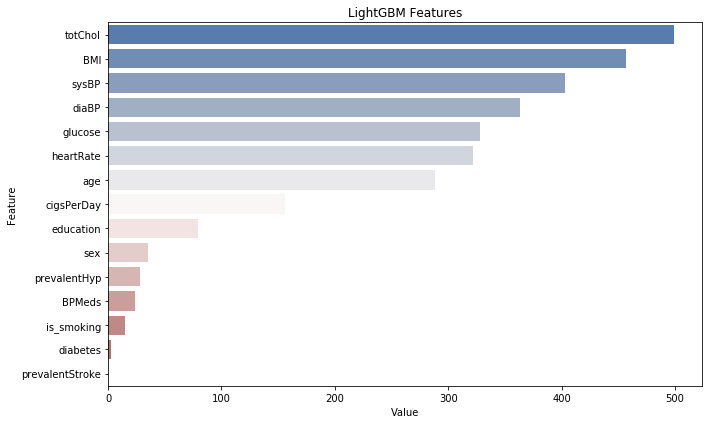

In [7]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), palette='vlag')
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()


features_selection = SelectFromModel(model, threshold='1.25*median') # The Threshold is the median of features importance*1.25 
features_selection.fit(X_train, y_train)


features_selection_support = features_selection.get_support()
features_selection = X_train.loc[:,features_selection_support].columns.tolist()

In [8]:
np.random.seed(42)
Seed = 0

kf = KFold(n_splits = 5, shuffle = False)
random_state = 42

#Test Different Algorithms
#Initialize a list of classifiers 
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state,warm_start=True))
classifiers.append(RandomForestClassifier(random_state=random_state,warm_start=True, class_weight='balanced_subsample'))
classifiers.append(ExtraTreesClassifier(random_state=random_state,warm_start=True))
classifiers.append(GradientBoostingClassifier(random_state=random_state,warm_start=True))
classifiers.append(MLPClassifier(random_state=random_state,warm_start=True))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state,warm_start=True, max_iter=1000000))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(lgb.LGBMClassifier())

#Run all models and return cross validation score, accuracy score, f1 score
cv_results = []
acc_results = []
f1_results = []


for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, 
                                      scoring = "accuracy", cv = kf, n_jobs=-1))
    classifier.fit(X_train,y_train)
    acc_results.append(accuracy_score(classifier.predict(X_test), y_test))
    f1_results.append(f1_score(y_test, classifier.predict(X_test)))


#Calculate means, std deviations 
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    

    
#Build a dataframe of results
cv_res = pd.DataFrame(
    {"CrossValMeans":cv_means,
     "CrossValerrors": cv_std,
     "Accuracy Scores": acc_results,
     "F1-Scores":f1_results,
     "Algorithm":['SVC','DecisionTree','AdaBoost',
                  'RandomForest', 'RandomForest-withBootstrap', 'ExtraTrees',
                  'GradientBoosting','MultipleLayerPerceptron',
                  'KNeighboors','LogisticRegression',
                  'LinearDiscriminantAnalysis','LightGBM']})



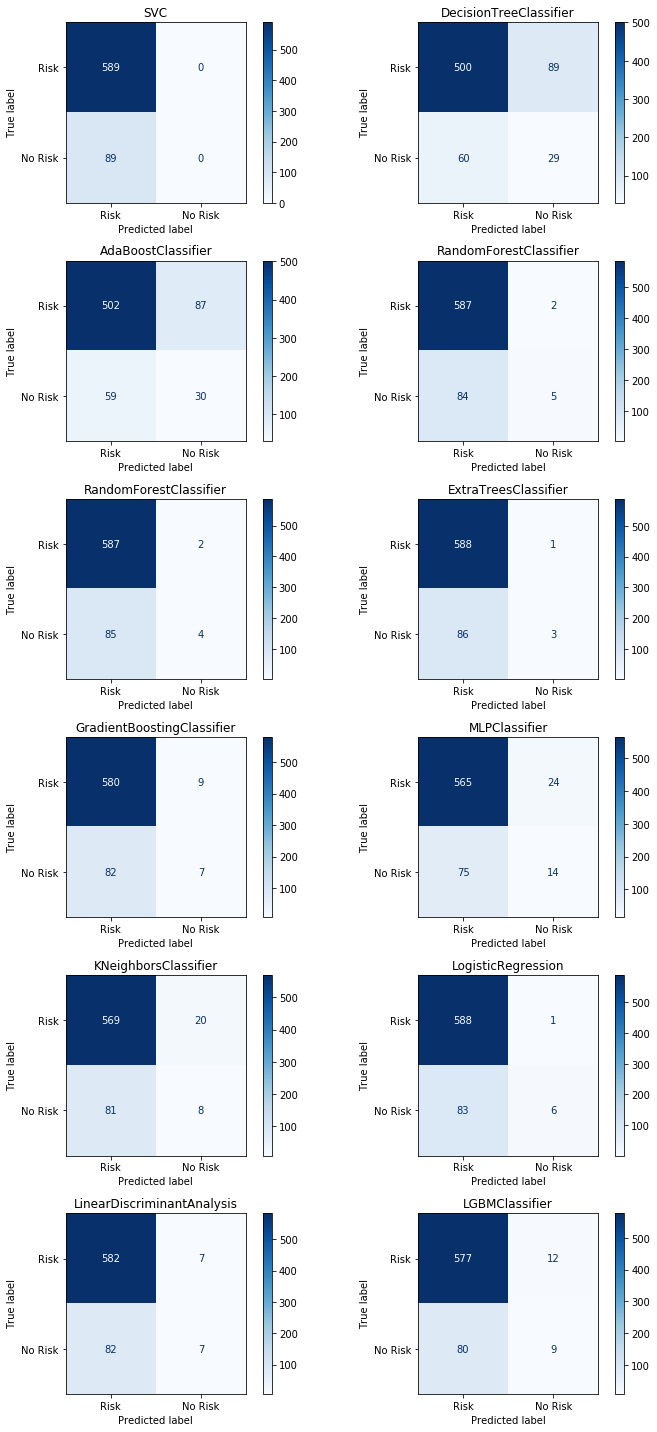

In [9]:
#Create loop to plot confusion matrix for each classifier 
CHDrisk = ['Risk', 'No Risk']
models = ['SVC','DecisionTree','AdaBoost',
                  'RandomForest', 'RandomForest-withBootstrap', 'ExtraTrees',
                  'GradientBoosting','MultipleLayerPerceptron',
                  'KNeighboors','LogisticRegression',
                  'LinearDiscriminantAnalysis','LightGBM']

for classifier in classifiers:
    model_fit = classifier.fit(X_train, y_train)


fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10,20))

for model_fit, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(model_fit, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                          display_labels = CHDrisk)
    ax.title.set_text(type(model_fit).__name__)


plt.yticks(rotation = 0)



plt.tight_layout()  


#save plot as image
plt.savefig(r'images/ML/CM_6x2.png', dpi=400, bbox_inches='tight')

plt.show()

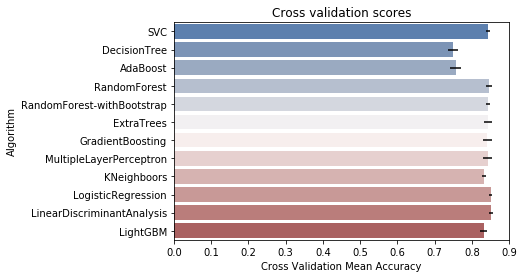

In [28]:
#Plot results 
ax = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="vlag",orient = "h",**{'xerr':cv_std})    
ax.set_xlabel("Cross Validation Mean Accuracy")
ax = ax.set_title("Cross validation scores")

#save plot as image
plt.savefig(r'images/ML/cross_validation_scores.png', dpi=400, bbox_inches='tight')
plt.show()

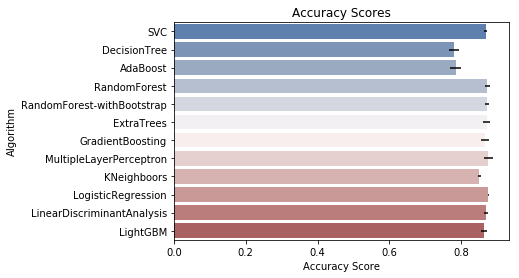

In [11]:
#Plot results 
ax = sns.barplot("Accuracy Scores","Algorithm",data = cv_res, palette="vlag",orient = "h",**{'xerr':cv_std})    
ax.set_xlabel("Accuracy Score")
ax = ax.set_title("Accuracy Scores")

#save plot as image
plt.savefig(r'images/ML/AccuracyScores.png', dpi=400, bbox_inches='tight')
plt.show()

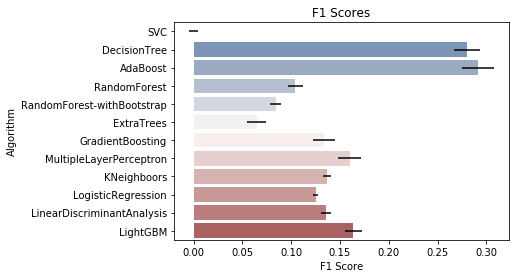

In [12]:
#Plot results 
ax = sns.barplot("F1-Scores","Algorithm",data = cv_res, palette="vlag",orient = "h",**{'xerr':cv_std})    
ax.set_xlabel("F1 Score")
ax = ax.set_title("F1 Scores")

#save plot as image
plt.savefig(r'images/ML/F1Scores.png', dpi=400, bbox_inches='tight')
plt.show()

In [13]:
cv_res.sort_values('Accuracy Scores', ascending = False)

,CrossValMeans,CrossValerrors,Accuracy Scores,F1-Scores,Algorithm
7,0.842551,0.012046,0.876106,0.160000,MultipleLayerPerceptron
9,0.850295,0.002730,0.876106,0.125000,LogisticRegression
3,0.846239,0.007874,0.873156,0.104167,RandomForest
4,0.842921,0.005732,0.871681,0.084211,RandomForest-withBootstrap
5,0.843657,0.009800,0.871681,0.064516,ExtraTrees
0,0.844025,0.004509,0.868732,0.000000,SVC
10,0.851400,0.005078,0.868732,0.135922,LinearDiscriminantAnalysis
6,0.841814,0.011153,0.865782,0.133333,GradientBoosting
11,0.832227,0.008874,0.864307,0.163636,LightGBM
8,0.832964,0.004304,0.851032,0.136752,KNeighboors


## Oversampling and undersampling

Since the dataset is imbalanced, with 2879 of 3390 data points being patients with no risk of developing CHD, an oversampling or undersampling process should be implemented.During model development, Random Forest with bootstrapping was implemented to see if utilizing under or oversampling would improve the model performance. The performance of both models was virtually identical. They had the same accuracy, but the model using bootstrapphing had a slightly higher F-score. One less patient was misclassified as having a risk for developing CHD in the confusion matrix. 

This slight improvement seemed worth further investigation. For this reason, we will now investigate using imblearn's oversampling and undersampling, and using a pipeline to test the most accurate model - Logistic Regression.  

Accuracy = 0.660218253968254
F1-score =  0.6552591847005536


(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

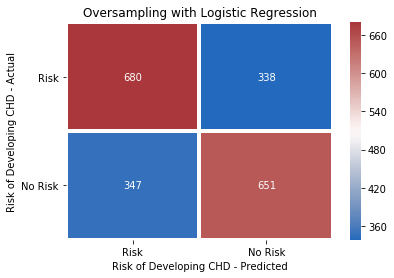

In [14]:
#Create oversampling dataset 
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
Xo_train, Xo_test, yo_train, yo_test = train_test_split(X_over,y_over,test_size=0.35)

steps = [('over', RandomOverSampler(sampling_strategy='minority')), 
         ('model', LogisticRegression(random_state = random_state,warm_start=True, max_iter=1000000))]
pipeline_over = Pipeline(steps=steps)

pipeline_over.fit(Xo_train,yo_train)
pipeline_over_pred = pipeline_over.predict(Xo_test)

#create confusion matrix
cm_over = confusion_matrix(pipeline_over_pred,yo_test)

#Print Accuracy
print('Accuracy =',accuracy_score(pipeline_over_pred, yo_test))

#Print F1- score 
print ("F1-score = ", f1_score(pipeline_over_pred, yo_test))

ax = sns.heatmap(cm_over,annot=True, fmt='g', xticklabels = CHDrisk, yticklabels=CHDrisk, 
                linewidths = 3, cmap = 'vlag')
ax.set(title = 'Oversampling with Logistic Regression',
      xlabel = 'Risk of Developing CHD - Predicted',
      ylabel = 'Risk of Developing CHD - Actual')
plt.yticks(rotation = 0)

Accuracy = 0.6815642458100558
F1-score =  0.6779661016949152


(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

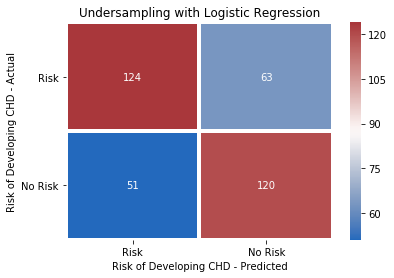

In [15]:
#Create undersampling dataset 
undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X, y)
Xu_train, Xu_test, yu_train, yu_test = train_test_split(X_under,y_under,test_size=0.35)


steps = [('under', RandomUnderSampler()), 
         ('model', LogisticRegression(random_state = random_state,warm_start=True, max_iter=1000000))]
pipeline_under = Pipeline(steps=steps)

pipeline_under.fit(Xu_train,yu_train)
pipeline_under_pred = pipeline_under.predict(Xu_test)

#create confusion matrix
cm_under = confusion_matrix(pipeline_under_pred,yu_test)

#Print Accuracy
print('Accuracy =',accuracy_score(pipeline_under_pred, yu_test))

#Print F1- score 
print ("F1-score = ", f1_score(pipeline_under_pred, yu_test))

ax = sns.heatmap(cm_under,annot=True, fmt='g', xticklabels = CHDrisk, yticklabels=CHDrisk, 
                linewidths = 3, cmap = 'vlag')
ax.set(title = 'Undersampling with Logistic Regression',
      xlabel = 'Risk of Developing CHD - Predicted',
      ylabel = 'Risk of Developing CHD - Actual')
plt.yticks(rotation = 0)


Accuracy = 0.6641865079365079
F1-score =  0.6596279537456009


(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

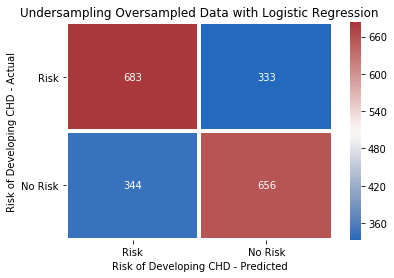

In [45]:
#Use oversampling dataset and undersample model 

steps1 = [('under', RandomUnderSampler()), 
         ('model', LogisticRegression(random_state = random_state,warm_start=True, max_iter=1000000))]
pipeline_under1 = Pipeline(steps=steps1)

pipeline_under1.fit(Xo_train,yo_train)
pipeline_under1_pred = pipeline_under1.predict(Xo_test)

#create confusion matrix
cm1_under = confusion_matrix(pipeline_under1_pred,yo_test)

#Print Accuracy
print('Accuracy =',accuracy_score(pipeline_under1_pred, yo_test))

#Print F1- score 
print ("F1-score = ", f1_score(pipeline_under1_pred, yo_test))

ax = sns.heatmap(cm1_under,annot=True, fmt='g', xticklabels = CHDrisk, yticklabels=CHDrisk, 
                linewidths = 3, cmap = 'vlag')
ax.set(title = 'Undersampling Oversampled Data with Logistic Regression',
      xlabel = 'Risk of Developing CHD - Predicted',
      ylabel = 'Risk of Developing CHD - Actual')
plt.yticks(rotation = 0)

Unfortuantely these scores are much worse, so this method isn't worth pursuing any further. 

## Removing lowest weighted variables
Let's finally try removing prevalence of stroke and the indicator for whether or not a patient is smoking and repeat the analysis for all models excluding the undersampling and oversampling using imblearn to see if scores can be improved any further. 


In [16]:
#Drop is_smoking and prevalentStroke from dataframes and create new test sets. 
#Define dataframes 
train_model_data_reduced = train_model_data.drop(['is_smoking' ,'prevalentStroke'], axis=1)
test_model_data_reduced =  test_model_data.drop(['is_smoking' ,'prevalentStroke'], axis=1)

#Save as dataframes for later use if necessary
train_model_data_reduced.to_csv(r'tidy_data/ML/train_model_data.csv',index=False)
test_model_data_reduced.to_csv(r'tidy_data/ML/test_model_data.csv',index=False)

#Split data into independent/dependent variables
Xr, yr = train_model_data_reduced.loc[:, train_model_data_reduced.columns != 'TenYearCHD'], train_model_data_reduced['TenYearCHD']

#First Split to save 20% of Data
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X,y, test_size = 0.2)

In [17]:
np.random.seed(42)
Seed = 0

kf = KFold(n_splits = 5, shuffle = False)
random_state = 42

#Test Different Algorithms
#Initialize a list of classifiers 
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state,warm_start=True))
classifiers.append(RandomForestClassifier(random_state=random_state,warm_start=True, class_weight='balanced_subsample'))
classifiers.append(ExtraTreesClassifier(random_state=random_state,warm_start=True))
classifiers.append(GradientBoostingClassifier(random_state=random_state,warm_start=True))
classifiers.append(MLPClassifier(random_state=random_state,warm_start=True))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state,warm_start=True, max_iter=1000000))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(lgb.LGBMClassifier())

#Run all models and return cross validation score, accuracy score, f1 score
cvr_results = []
accr_results = []
f1r_results = []


for classifier in classifiers :
    cvr_results.append(cross_val_score(classifier, Xr_train, y = yr_train, 
                                      scoring = "accuracy", cv = kf, n_jobs=-1))
    classifier.fit(Xr_train,yr_train)
    accr_results.append(accuracy_score(classifier.predict(Xr_test), yr_test))
    f1r_results.append(f1_score(yr_test, classifier.predict(Xr_test)))


#Calculate means, std deviations 
cvr_means = []
cvr_std = []
for cvr_result in cvr_results:
    cvr_means.append(cvr_result.mean())
    cvr_std.append(cvr_result.std())
    

    
#Build a dataframe of results
cvr_res = pd.DataFrame(
    {"CrossValMeans":cvr_means,
     "CrossValerrors": cvr_std,
     "Accuracy Scores": accr_results,
     "F1-Scores":f1r_results,
     "Algorithm":['SVC','DecisionTree','AdaBoost',
                  'RandomForest', 'RandomForest-withBootstrap', 'ExtraTrees',
                  'GradientBoosting','MultipleLayerPerceptron',
                  'KNeighboors','LogisticRegression',
                  'LinearDiscriminantAnalysis','LightGBM']})



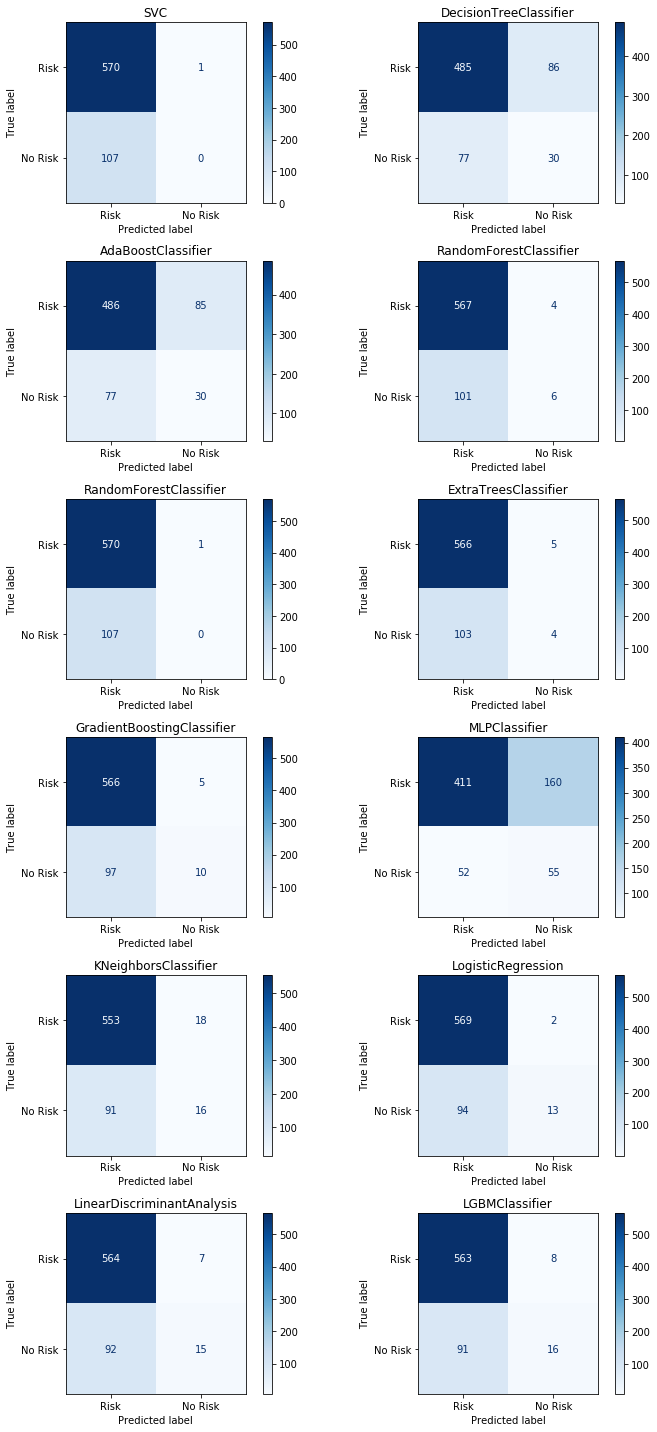

In [18]:
#Create loop to plot confusion matrix for each classifier 
CHDrisk = ['Risk', 'No Risk']
models = ['SVC','DecisionTree','AdaBoost',
                  'RandomForest', 'RandomForest-withBootstrap', 'ExtraTrees',
                  'GradientBoosting','MultipleLayerPerceptron',
                  'KNeighboors','LogisticRegression',
                  'LinearDiscriminantAnalysis','LightGBM']

for classifier in classifiers:
    model_fit = classifier.fit(Xr_train, yr_train)


fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10,20))

for model_fit, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(model_fit, 
                          Xr_test, 
                          yr_test, 
                          ax=ax, 
                          cmap='Blues',
                          display_labels = CHDrisk)
    ax.title.set_text(type(model_fit).__name__)
    

plt.yticks(rotation = 0)

plt.tight_layout()  


#save plot as image
plt.savefig(r'images/ML/CMReduced_6x2.png', dpi=400, bbox_inches='tight')

plt.show()

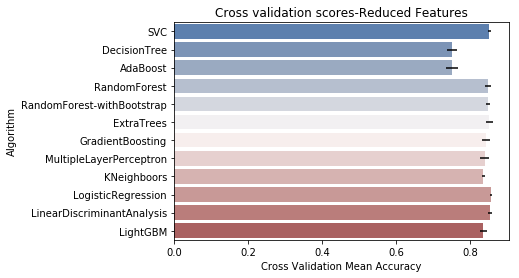

In [19]:
#Plot results 
ax = sns.barplot("CrossValMeans","Algorithm",data = cvr_res, palette="vlag",orient = "h",**{'xerr':cv_std})    
ax.set_xlabel("Cross Validation Mean Accuracy")
ax = ax.set_title("Cross validation scores-Reduced Features")

#save plot as image
plt.savefig(r'images/ML/cross_validation_scores_reduced.png', dpi=400, bbox_inches='tight')
plt.show()

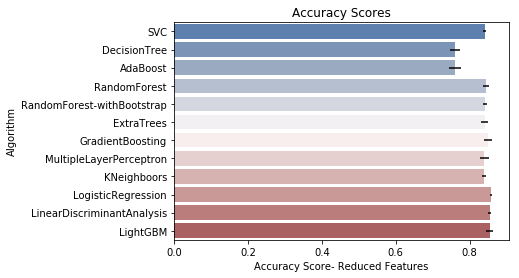

In [20]:
#Plot results 
ax = sns.barplot("Accuracy Scores","Algorithm",data = cvr_res, palette="vlag",orient = "h",**{'xerr':cv_std})    
ax.set_xlabel("Accuracy Score- Reduced Features")
ax = ax.set_title("Accuracy Scores")

#save plot as image
plt.savefig(r'images/ML/AccuracyScores_reduced.png', dpi=400, bbox_inches='tight')
plt.show()

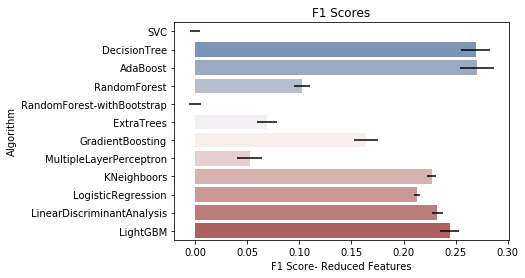

In [21]:
#Plot results 
ax = sns.barplot("F1-Scores","Algorithm",data = cvr_res, palette="vlag",orient = "h",**{'xerr':cv_std})    
ax.set_xlabel("F1 Score- Reduced Features")
ax = ax.set_title("F1 Scores")

#save plot as image
plt.savefig(r'images/ML/F1Scores_reduced.png', dpi=400, bbox_inches='tight')
plt.show()

In [22]:
cvr_res.sort_values('Accuracy Scores', ascending = False)

,CrossValMeans,CrossValerrors,Accuracy Scores,F1-Scores,Algorithm
9,0.855447,0.018780,0.858407,0.213115,LogisticRegression
10,0.853603,0.016797,0.853982,0.232558,LinearDiscriminantAnalysis
11,0.835171,0.010496,0.853982,0.244275,LightGBM
6,0.842542,0.014776,0.849558,0.163934,GradientBoosting
3,0.848075,0.017797,0.845133,0.102564,RandomForest
0,0.851393,0.019160,0.840708,0.000000,SVC
4,0.848812,0.019141,0.840708,0.000000,RandomForest-withBootstrap
5,0.851024,0.017333,0.840708,0.068966,ExtraTrees
7,0.838503,0.011296,0.839233,0.052174,MultipleLayerPerceptron
8,0.835536,0.017997,0.839233,0.226950,KNeighboors


In [23]:
#Add column to distinguish between reduced or full features to each set of results
cv_res['Features'] = 'all'
cvr_res['Features'] = 'reduced'

#Combine results dataframes
analysis_results = pd.concat([cv_res, cvr_res], axis = 0, ignore_index=True)

#Save as dataframes for later use if necessary
analysis_results.to_csv(r'tidy_data/ML/analysis_results.csv',index=False)

In [24]:
analysis_results

,CrossValMeans,CrossValerrors,Accuracy Scores,F1-Scores,Algorithm,Features
0,0.844025,0.004509,0.868732,0.000000,SVC,all
1,0.749642,0.013623,0.780236,0.280193,DecisionTree,all
2,0.756278,0.016069,0.784661,0.291262,AdaBoost,all
3,0.846239,0.007874,0.873156,0.104167,RandomForest,all
4,0.842921,0.005732,0.871681,0.084211,RandomForest-withBootstrap,all
5,0.843657,0.009800,0.871681,0.064516,ExtraTrees,all
6,0.841814,0.011153,0.865782,0.133333,GradientBoosting,all
7,0.842551,0.012046,0.876106,0.160000,MultipleLayerPerceptron,all
8,0.832964,0.004304,0.851032,0.136752,KNeighboors,all
9,0.850295,0.002730,0.876106,0.125000,LogisticRegression,all


## Summary 


The data was studied using the same machine learning models but a different selection of features. Overall, the reduced feature data had higher deviations when looking at results of cross validation. However, when looking at accuracy, the reduced features models tended to have higher accuracies. This is possibly due to the model overfitting the data. The best model for the dataset without overfitting would require access to the solutions for the train data, which are not available at this time. Access has been requested with no response to date. 
Logistic Regression  was found to be the most accurate of models used when only considering within group results. That is to say when only looking at models analyzing all features or models analyzing reduced features. When considering both modeled datasets together, Gradient boosting or Random forest were the most accurate models. They had a cross validation accuracy of approximately 84% +/- 1%.  
Given the clients expressed goals, and knowing the risk of failing to identify a risk of CHD, it was determined that that model accuracy should be prioritized by least number of patients classified as having no risk who actually have risk. Based on confusion matrix results for these four models (Fig. 1)  the best model is to use Logistic Regression with the entire feature set. This results in the least number of patients with risk who are not alerted, which is most critical. Accuracy for this dataset is 85% when using the cross-validation accuracy score. Even though the reduced data yielded better results for accuracy when patients who do not have a risk are identified as having a risk, those patients at risk who were not identified were determined to be the most critical. 

A complete summary of the model accuracy scores can be seen in Table 1 below. Additional details regarding accuracy scores can be seen in Appendix A. 

![Final Machine Learning Scores, Summary](Images/ML/Machine_Learning_Summary_Results.png "Final Machine Learning Model Scores")


## Additional Figures for Report Out to Client

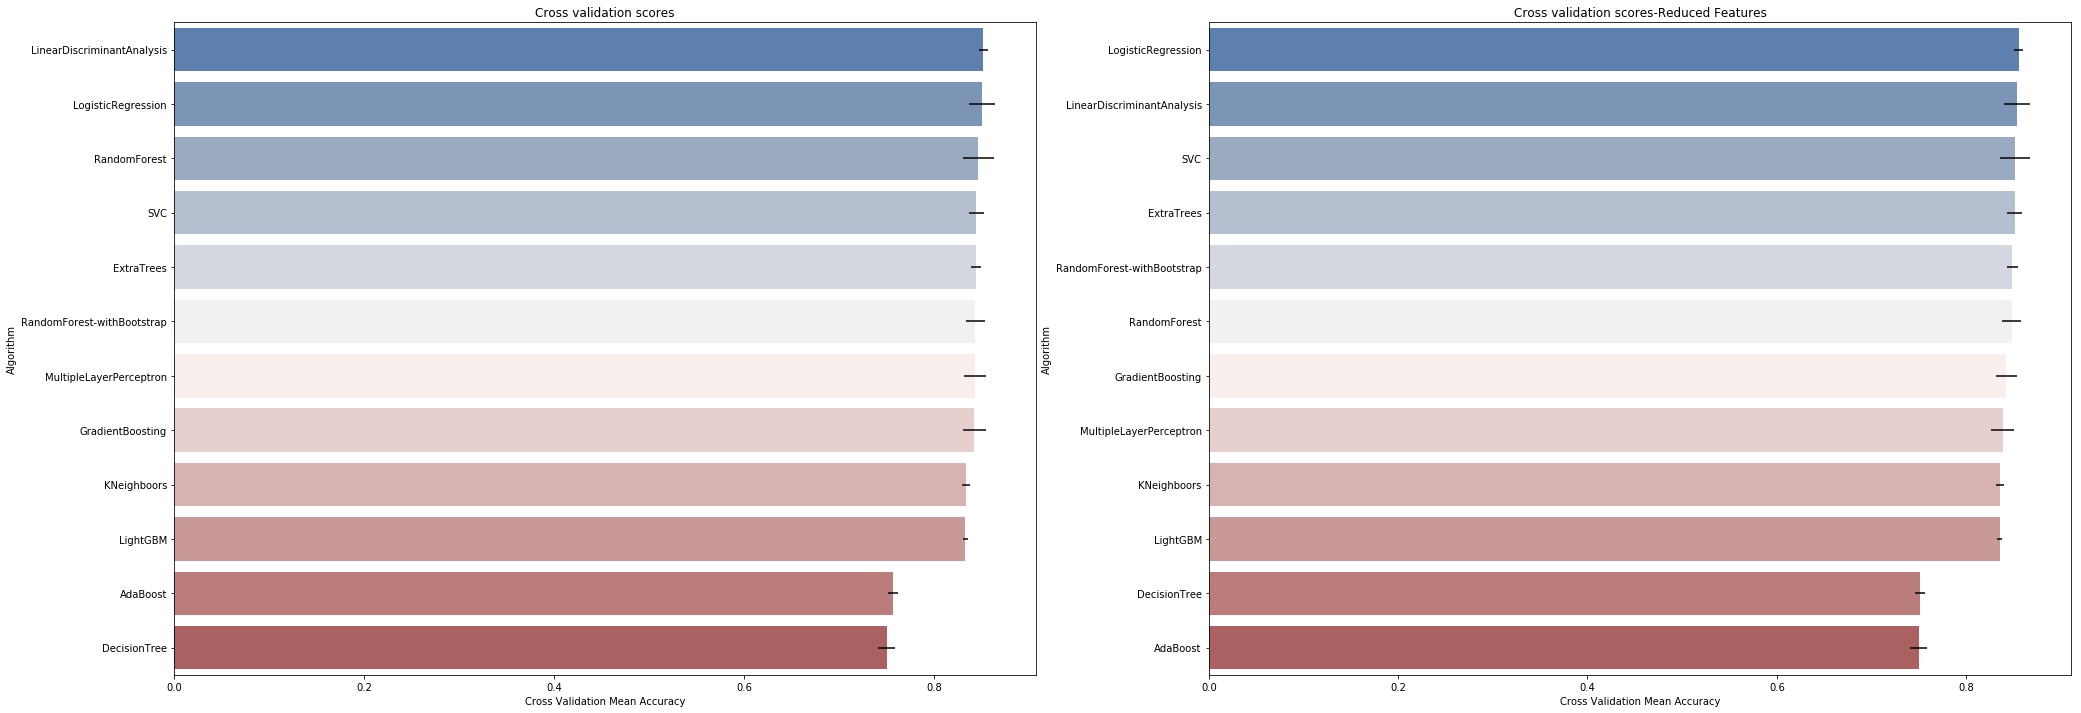

In [40]:
#Create Figure 
fig, ax = plt.subplots(figsize = (34, 12))

#Create Plot
plt.subplot(1,2,1)
ax = sns.barplot("CrossValMeans","Algorithm",data = cv_res.sort_values(by=['CrossValMeans'],ascending=False),
                 palette="vlag",orient = "h",**{'xerr':cv_std})    
ax.set_xlabel("Cross Validation Mean Accuracy")
ax = ax.set_title("Cross validation scores")


plt.subplot(1,2,2)
#Plot results 
ax1 = sns.barplot("CrossValMeans","Algorithm",data = cvr_res.sort_values(by=['CrossValMeans'],ascending=False),
                  palette="vlag",orient = "h",**{'xerr':cv_std})    
ax1.set_xlabel("Cross Validation Mean Accuracy")
ax1 = ax1.set_title("Cross validation scores-Reduced Features")

#save plot as image
plt.savefig(r'images/ML/cross_validation_scores_sidebyside.png', dpi=400, bbox_inches='tight')
plt.show()

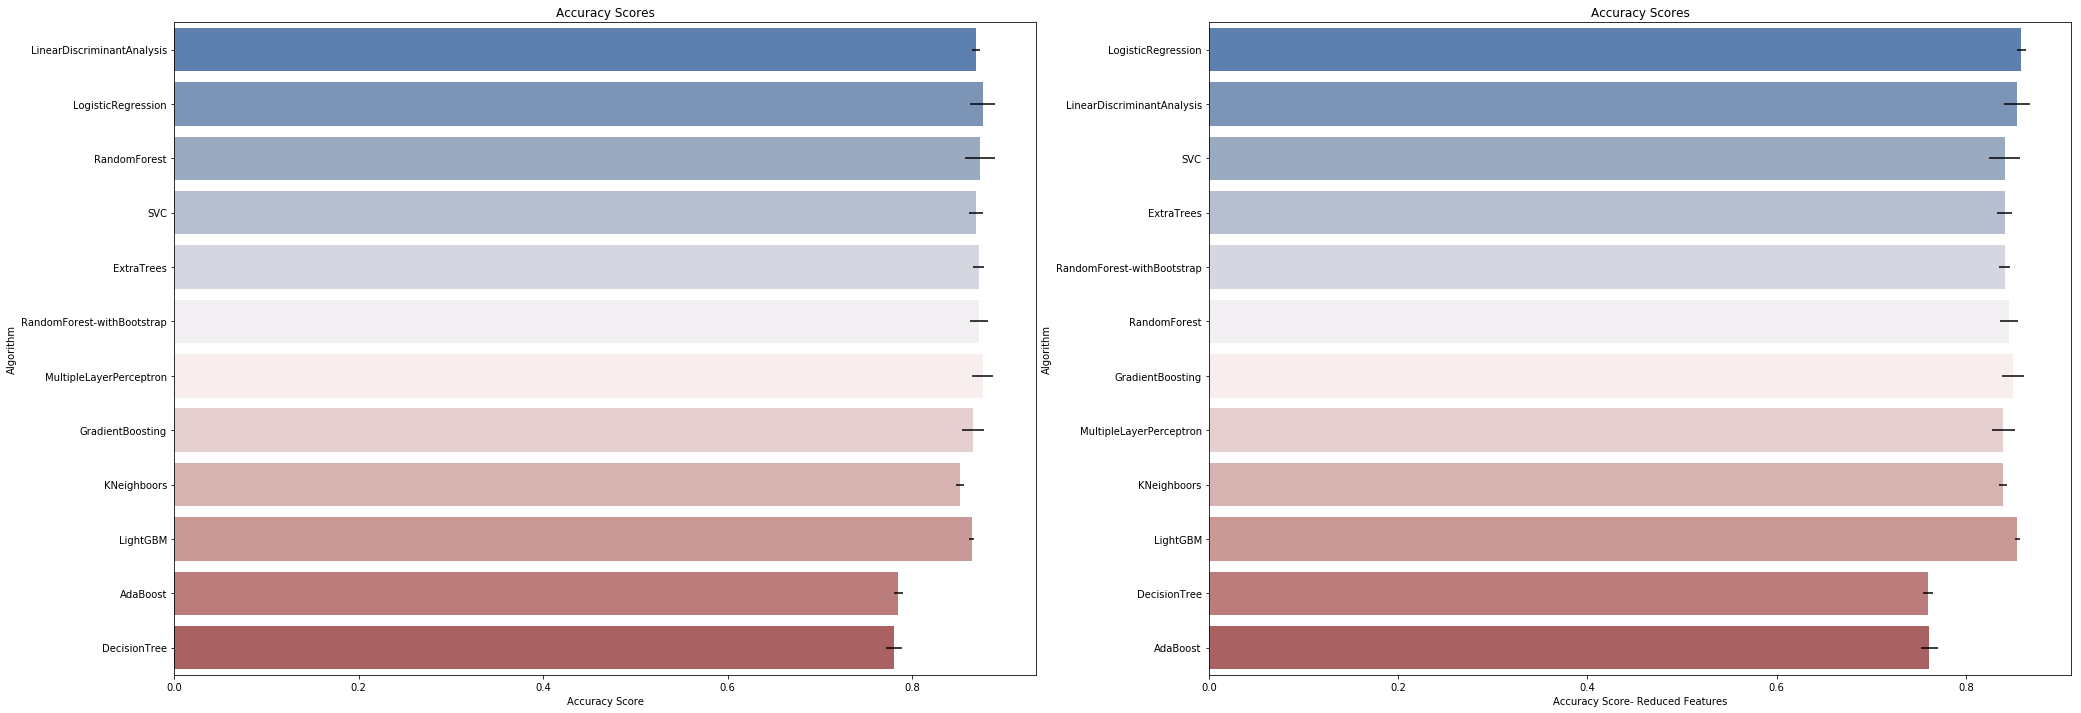

In [41]:
#Create Figure 
fig, ax = plt.subplots(figsize = (34, 12))

#Create Plot
plt.subplot(1,2,1)
#Plot results 
ax = sns.barplot("Accuracy Scores","Algorithm",data = cv_res.sort_values(by=['CrossValMeans'],ascending=False),
                 palette="vlag",orient = "h",**{'xerr':cv_std})    
ax.set_xlabel("Accuracy Score")
ax = ax.set_title("Accuracy Scores")



plt.subplot(1,2,2)
#Plot results 
ax1 = sns.barplot("Accuracy Scores","Algorithm", data = cvr_res.sort_values(by=['CrossValMeans'],ascending=False),
                 palette="vlag",orient = "h",**{'xerr':cv_std})    
ax1.set_xlabel("Accuracy Score- Reduced Features")
ax1 = ax1.set_title("Accuracy Scores")


#save plot as image
plt.savefig(r'images/ML/accuracy_scores_sidebyside.png', dpi=400, bbox_inches='tight')
plt.show()

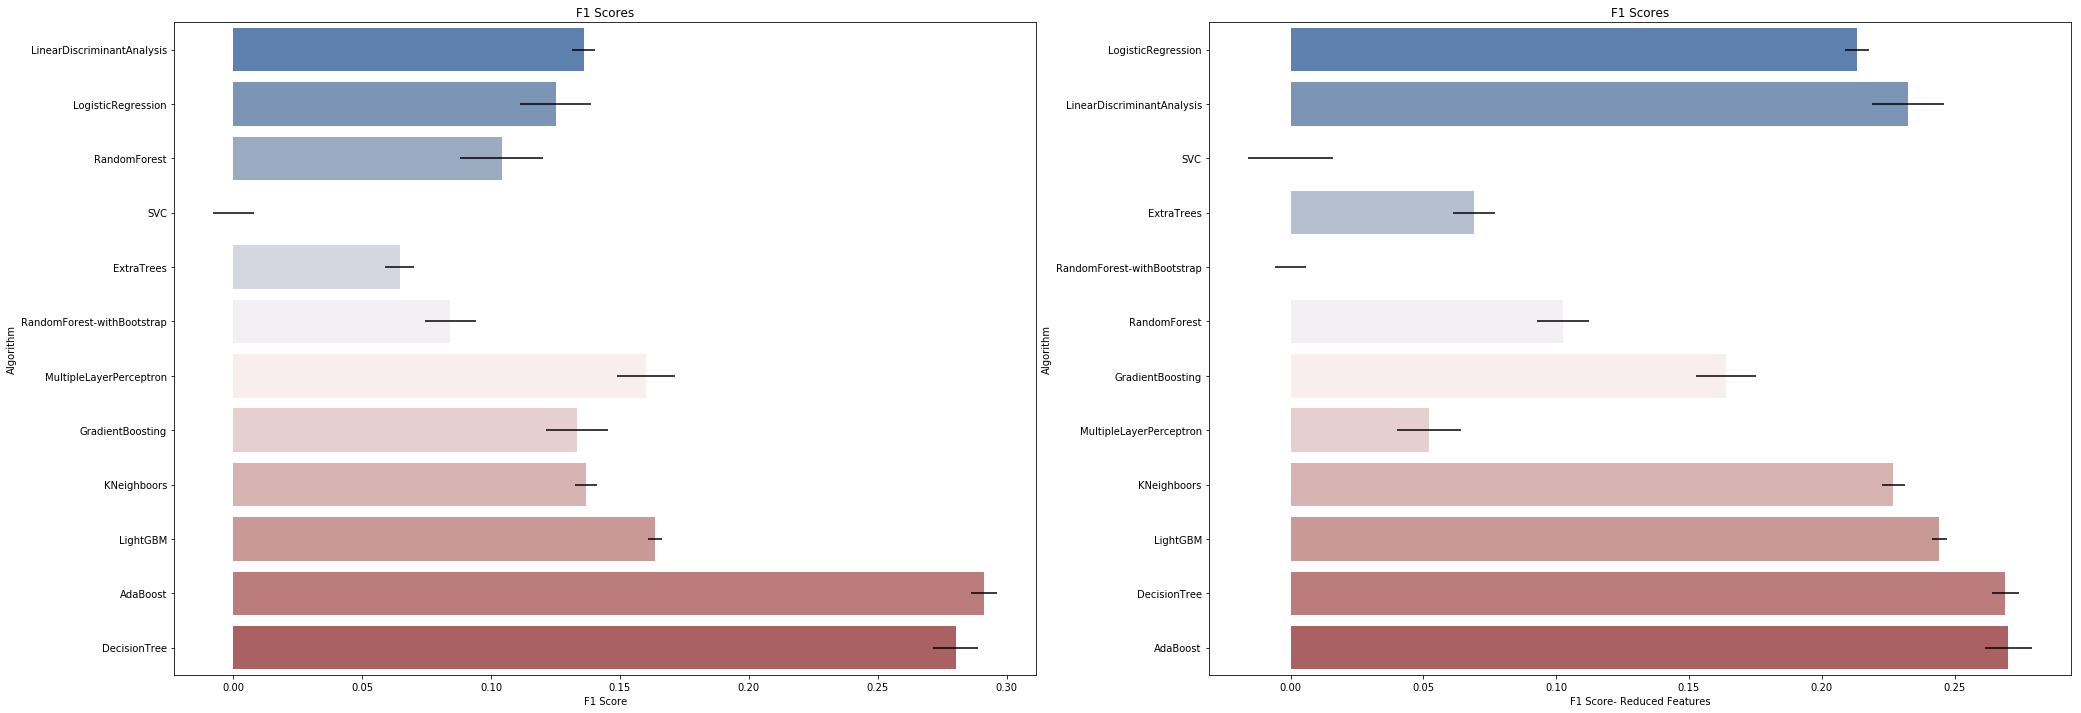

In [42]:
#Create Figure 
fig, ax = plt.subplots(figsize = (34, 12))

#Create Plot
plt.subplot(1,2,1)
#Plot results 
ax = sns.barplot("F1-Scores","Algorithm",data = cv_res.sort_values(by=['CrossValMeans'],ascending=False),
                 palette="vlag",orient = "h",**{'xerr':cv_std})    
ax.set_xlabel("F1 Score")
ax = ax.set_title("F1 Scores")



plt.subplot(1,2,2)
#Plot results 
ax1 = sns.barplot("F1-Scores","Algorithm",data = cvr_res.sort_values(by=['CrossValMeans'],ascending=False),
                 palette="vlag",orient = "h",**{'xerr':cv_std})    
ax1.set_xlabel("F1 Score- Reduced Features")
ax1 = ax1.set_title("F1 Scores")


#save plot as image
plt.savefig(r'images/ML/f1_scores_sidebyside.png', dpi=400, bbox_inches='tight')
plt.show()

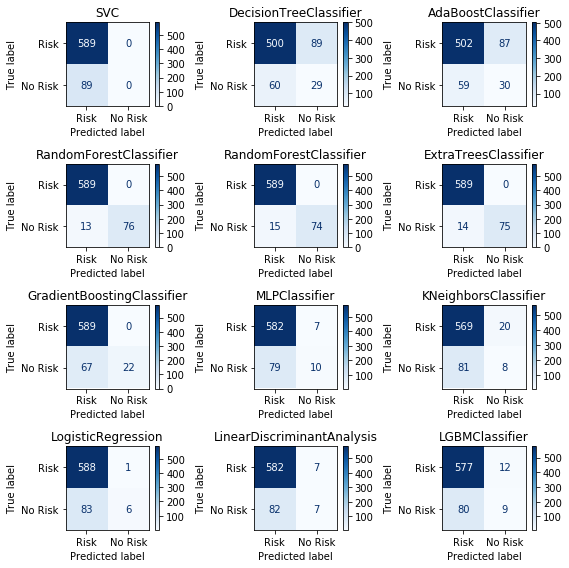

In [57]:
#Create loop to plot confusion matrix for each classifier 
CHDrisk = ['Risk', 'No Risk']
models = ['SVC','DecisionTree','AdaBoost',
                  'RandomForest', 'RandomForest-withBootstrap', 'ExtraTrees',
                  'GradientBoosting','MultipleLayerPerceptron',
                  'KNeighboors','LogisticRegression',
                  'LinearDiscriminantAnalysis','LightGBM']

for classifier in classifiers:
    model_fit = classifier.fit(X_train, y_train)


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8,8))

for model_fit, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(model_fit, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                          display_labels = CHDrisk)
    ax.title.set_text(type(model_fit).__name__)


plt.yticks(rotation = 0)



plt.tight_layout()  


#save plot as image
plt.savefig(r'images/ML/CM_4x3SM.png', dpi=400, bbox_inches='tight')

plt.show()

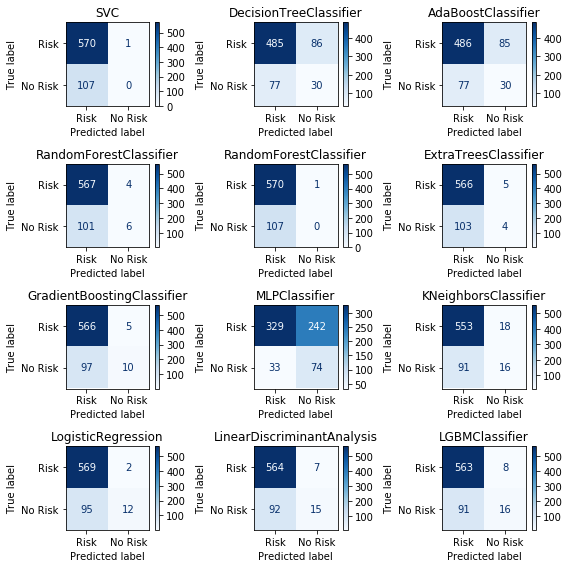

In [56]:
#Create loop to plot confusion matrix for each classifier 
CHDrisk = ['Risk', 'No Risk']
models = ['SVC','DecisionTree','AdaBoost',
                  'RandomForest', 'RandomForest-withBootstrap', 'ExtraTrees',
                  'GradientBoosting','MultipleLayerPerceptron',
                  'KNeighboors','LogisticRegression',
                  'LinearDiscriminantAnalysis','LightGBM']

for classifier in classifiers:
    model_fit = classifier.fit(Xr_train, yr_train)


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8,8))

for model_fit, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(model_fit, 
                          Xr_test, 
                          yr_test, 
                          ax=ax, 
                          cmap='Blues',
                          display_labels = CHDrisk)
    ax.title.set_text(type(model_fit).__name__)
    

plt.yticks(rotation = 0)

plt.tight_layout()  


#save plot as image
plt.savefig(r'images/ML/CMReduced_4X3SM.png', dpi=400, bbox_inches='tight')

plt.show()